In [ ]:


import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Synthetic data loader to load 3D data for sphere, for classification
def synthetic_3d_sphere_dataloader(num_samples, radius=1.0, batch_size=32):
    # Generate synthetic 3D sphere data with points inside and outside the sphere
    points = []
    labels = []
    for _ in range(num_samples):
        # Generate random points within a cube
        point = 2 * (torch.rand(3) - 0.5) * (radius + 1)  # Points within a cube

        # Calculate distance from the origin
        distance = torch.norm(point)

        # Assign label based on distance from origin (inside or outside sphere)
        label = 1 if distance <= radius else 0

        # if label == 0:
        #     # do a toss
        #     if torch.rand(1) > 0.75:
        #         points.append(point)
        #         labels.append(label)
        # else:
        points.append(point)
        labels.append(label)

    points = torch.stack(points)
    labels = torch.tensor(labels)
    dataset = torch.utils.data.TensorDataset(points, labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


# Create a synthetic dataloader
dataloader = synthetic_3d_sphere_dataloader(num_samples=5000)

# Extract points and labels from the dataloader
points = []
labels = []
for batch_data, batch_labels in dataloader:
    points.append(batch_data)
    labels.append(batch_labels)
points = torch.cat(points)
labels = torch.cat(labels)

# Separate points based on labels
inside_sphere = points[labels == 1]
outside_sphere = points[labels == 0]

import plotly.graph_objects as go
import numpy as np

# Create a 3D scatter plot using Plotly
fig = go.Figure()

# Add traces for points inside and outside the sphere
fig.add_trace(go.Scatter3d(x=inside_sphere[:, 0], y=inside_sphere[:, 1], z=inside_sphere[:, 2], mode='markers', marker=dict(size=2, color='blue'), name='Inside'))
fig.add_trace(go.Scatter3d(x=outside_sphere[:, 0], y=outside_sphere[:, 1], z=outside_sphere[:, 2], mode='markers', marker=dict(size=2, color='red'), name='Outside'))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Sphere Classification (Plotly)'
)

# Show the plot
fig.show()

# Example of creating a cross-section (assuming you want the XY plane)
xy_plane_points_inside = inside_sphere[np.abs(inside_sphere[:,2]) < 0.1] #Adjust 0.1 to control the thickness
xy_plane_points_outside = outside_sphere[np.abs(outside_sphere[:,2]) < 0.1]

fig_xy = go.Figure()
fig_xy.add_trace(go.Scatter(x=xy_plane_points_inside[:,0], y=xy_plane_points_inside[:,1], mode='markers', marker=dict(size=4, color='blue'), name='Inside'))
fig_xy.add_trace(go.Scatter(x=xy_plane_points_outside[:,0], y=xy_plane_points_outside[:,1], mode='markers', marker=dict(size=4, color='red'), name='Outside'))
fig_xy.update_layout(title="Cross-section at Z=0 (XY plane)")
fig_xy.show()

In [ ]:
# Build a model and train it on the sphere data

import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class SphereClassifier(nn.Module):
    def __init__(self):
        super(SphereClassifier, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.silu = nn.SiLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.silu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model, loss function, and optimizer
model = SphereClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs.squeeze(), batch_labels.float()) # Ensure correct shapes
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished.")

Epoch [1/10], Loss: 0.2077
Epoch [2/10], Loss: 0.2888
Epoch [3/10], Loss: 0.3114
Epoch [4/10], Loss: 0.4743
Epoch [5/10], Loss: 0.0313
Epoch [6/10], Loss: 0.1450
Epoch [7/10], Loss: 0.0217
Epoch [8/10], Loss: 0.0465
Epoch [9/10], Loss: 0.1574
Epoch [10/10], Loss: 0.0393
Training finished.


In [ ]:
# Check accuracy

# Evaluation loop
correct_predictions = 0
total_samples = 0
with torch.no_grad():  # Disable gradient calculations during evaluation
    for batch_data, batch_labels in dataloader:
        outputs = model(batch_data)
        predicted_labels = (outputs > 0.5).float() # Apply threshold to get predicted labels
        correct_predictions += (predicted_labels.squeeze() == batch_labels.float()).sum().item()
        total_samples += batch_labels.size(0)

accuracy = correct_predictions / total_samples
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.74%


In [ ]:


import torch

torch.save(model.state_dict(), '/content/sphere_model.pth')


In [ ]:
!pip install livelossplot
!pip install imageio-ffmpeg

Sigmoid

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def fn(out_pre,model_dict_ls,li):
    if li == len(model_dict_ls)/2:
        return out_pre
    out_cur = []
    for i in range(len(model_dict_ls[2*li])):
        x = 0
        for j in range(len(out_pre)):
            x = x + out_pre[j]*model_dict_ls[2*li][i][j]
        if li == (len(model_dict_ls)/2)-1:
            out_cur.append(x+model_dict_ls[2*li+1][i])
        else:
            out_cur.append(sigmoid(x+model_dict_ls[2*li+1][i]))
    li+=1
    return fn(np.array(out_cur),model_dict_ls,li)

SiLU

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def fn(out_pre,model_dict_ls,li):
    if li == len(model_dict_ls)/2:
        return out_pre
    out_cur = []
    for i in range(len(model_dict_ls[2*li])):
        x = 0
        for j in range(len(out_pre)):
            x = x + out_pre[j]*model_dict_ls[2*li][i][j]
        out_cur.append((x+model_dict_ls[2*li+1][i])*sigmoid(x+model_dict_ls[2*li+1][i]))
    li+=1
    return fn(np.array(out_cur),model_dict_ls,li)

SiLU + Final layer Sigmoid

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def fn(out_pre,model_dict_ls,li):
    if li == len(model_dict_ls)/2:
        return out_pre
    out_cur = []
    for i in range(len(model_dict_ls[2*li])):
        x = 0
        for j in range(len(out_pre)):
            x = x + out_pre[j]*model_dict_ls[2*li][i][j]
        if li == (len(model_dict_ls)/2)-1:
            out_cur.append(sigmoid(x+model_dict_ls[2*li+1][i]))
        else:
            out_cur.append((x+model_dict_ls[2*li+1][i])*sigmoid(x+model_dict_ls[2*li+1][i]))
    li+=1
    return fn(np.array(out_cur),model_dict_ls,li)

Helpers

In [ ]:

def get_square_slice_from_one_anchor(anchors,pad_dist=1,seed=None):
    """
    Given one vector as an anchor, takes a randomly oriented slice with the anchor at the center
    """
#     if seed is not None:
#         torch.manual_seed(seed)

    assert len(anchors) == 1

    centroid = anchors[0]

    z1 = torch.randn_like(anchors[0])
    z2 = torch.randn_like(anchors[0])

    u1 = z1
    u2 = z2 - (u1.T @ z2)/(u1.T @ u1)*u1

    dirs = torch.vstack([u1,u2])
    dirs /= torch.linalg.norm(dirs,dim=-1,keepdim=True)
    domain = torch.vstack([centroid+pad_dist*dirs,centroid-pad_dist*dirs])
    domain_poly = torch.vstack([domain,domain[:1]])

    return domain_poly



def get_square_slice_from_two_anchors(anchors,pad_dist=1,seed=-1):

    if not seed == -1: #None buggy for jit
        torch.manual_seed(seed)

    assert len(anchors) == 2

    centroid = torch.mean(anchors,dim=0)

    u1 = anchors[0] - centroid
    z = torch.randn_like(anchors[0])
    u2 = z - (u1.T @ z)/(u1.T @ u1)*u1

    dirs = torch.vstack([u1,u2])
    dirs /= torch.linalg.norm(dirs,dim=-1,keepdim=True)
    domain = torch.vstack([centroid+pad_dist*dirs,centroid-pad_dist*dirs])
    domain_poly = torch.vstack([domain,domain[:1]])

    return domain_poly

def get_proj_mat(domain):

    v1 = domain[1] - domain[0]
    v2 = domain[-2] - domain[0]

    v = torch.vstack([v1,v2])
    v /= torch.linalg.norm(v,dim=-1,keepdim=True)

    return torch.hstack([v.T,domain.mean(0,keepdim=True).T])

In [ ]:
# prompt: put these two points in a variable called samples, these two points must be tensors and samples is a list
# Vector from inside the sphere: tensor([0.0674, 0.1110, 0.6958])
# Vector from outside the sphere: tensor([-0.5406, -1.8895, -0.6052])

samples = [torch.tensor([0.0674, 0.1110, 0.6958]), torch.tensor([-0.5406, -1.8895, -0.6052])]

In [ ]:
samples = []
inside_vector = inside_sphere[0]  # Take the first vector from the inside_sphere tensor

# Get a vector from outside the sphere
outside_vector = outside_sphere[0] # Take the first vector from the outside_sphere tensor

print("Vector from inside the sphere:", inside_vector)
print("Vector from outside the sphere:", outside_vector)

samples.append(inside_vector)
samples.append(outside_vector)

stacked_samples = torch.stack(samples)

#domain = get_square_slice_from_two_anchors(torch.randn(2,in_shape),pad_dist=2,seed=None)
domain = get_square_slice_from_two_anchors(stacked_samples,pad_dist=2,seed=42)

Vector from inside the sphere: tensor([0.0674, 0.1110, 0.6958])
Vector from outside the sphere: tensor([-0.5406, -1.8895, -0.6052])


<ipython-input-26-f19e1f751eda>:38: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)



In [ ]:
stacked_samples = torch.stack(samples)

#domain = get_square_slice_from_two_anchors(torch.randn(2,in_shape),pad_dist=2,seed=None)
domain = get_square_slice_from_two_anchors(stacked_samples,pad_dist=2,seed=42)

<ipython-input-12-ad343c61b9f0>:38: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)



In [ ]:
domain

tensor([[ 0.2572,  0.7355,  1.1019],
        [ 1.5165, -1.7285,  0.5166],
        [-0.7304, -2.5140, -1.0113],
        [-1.9897, -0.0500, -0.4260],
        [ 0.2572,  0.7355,  1.1019]])

In [ ]:
domain

tensor([[ 0.2572,  0.7355,  1.1020],
        [ 1.5166, -1.7285,  0.5166],
        [-0.7304, -2.5139, -1.0113],
        [-1.9897, -0.0499, -0.4259],
        [ 0.2572,  0.7355,  1.1020]])

In [ ]:
# Plot the polygon of domain on top of the 3d plot using the new library with a thicker stroke

import plotly.graph_objects as go

# Create a scatter plot trace for the domain polygon with a thicker line
domain_trace = go.Scatter3d(
    x=domain[:, 0],
    y=domain[:, 1],
    z=domain[:, 2],
    mode='lines',  # Display as lines
    line=dict(width=5, color='black'),  # Set line width and color
    name='Domain Polygon'
)

# Add the domain trace to the existing figure
fig.add_trace(domain_trace)

# Show the updated plot
fig.show()

In [ ]:
# Plot the polygon of domain on top of the 3d plot using the new library with a thicker stroke

import plotly.graph_objects as go

# Create a scatter plot trace for the domain polygon with a thicker line
domain_trace = go.Scatter3d(
    x=domain[:, 0],
    y=domain[:, 1],
    z=domain[:, 2],
    mode='lines',  # Display as lines
    line=dict(width=5, color='black'),  # Set line width and color
    name='Domain Polygon'
)

# Add the domain trace to the existing figure
fig.add_trace(domain_trace)

# Show the updated plot
fig.show()

In [ ]:
domain

tensor([[ 0.2572,  0.7355,  1.1020],
        [ 1.5166, -1.7285,  0.5166],
        [-0.7304, -2.5139, -1.0113],
        [-1.9897, -0.0499, -0.4259],
        [ 0.2572,  0.7355,  1.1020]])

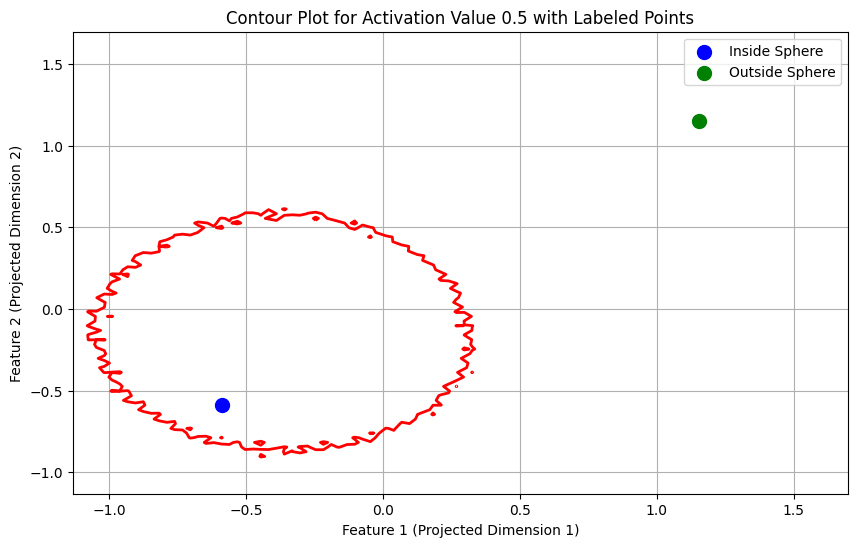

In [ ]:
#fig, ax = plt.subplots(1, 1, figsize=(12, 5))

samples = []
for i, (data, labels) in enumerate(dataloader):
    samples.append(data[0])  # Get the first data point from the batch
    if len(samples) == 2:
        break

# Get a vector from inside the sphere
inside_vector = inside_sphere[0]  # Take the first vector from the inside_sphere tensor

# Get a vector from outside the sphere
outside_vector = outside_sphere[0] # Take the first vector from the outside_sphere tensor

print("Vector from inside the sphere:", inside_vector)
print("Vector from outside the sphere:", outside_vector)

samples.append(inside_vector)
samples.append(outside_vector)

stacked_samples = torch.stack(samples)

domain = get_square_slice_from_two_anchors(stacked_samples,pad_dist=2,seed=42).cpu().numpy()

# Example Usage
# domain = np.array([[0.2572, 0.7355, 1.1020],
#                    [1.5166, -1.7285, 0.5166],
#                    [-0.7304, -2.5139, -1.0113],
#                    [-1.9897, -0.0499, -0.4259],
#                    [0.2572, 0.7355, 1.1020]])  # Example square domain

model_dict_ls = [np.array(ls.cpu()) for ls in list(model.state_dict().values())]
X_ls = []
for i in range(len(domain[0])):
    xx = np.linspace(domain[:, i].min(),domain[:, i].max(), 100)
    X_ls.append(xx)
X = np.meshgrid(*X_ls)
Z = fn(np.array(X),model_dict_ls,0)[0]
Y = np.stack(X, axis=-1)

import numpy as np

def is_point_in_domain_region(point, domain):
    """
    Generalized function to check if an n-dimensional point is in the domain region.
    The domain is assumed to be a hyperplane or a region bounded by `domain`.
    """
    # Compute domain normal using the first and last two points of the domain
    domain_normal = np.cross(domain[1] - domain[0], domain[-2] - domain[0])
    domain_normal /= np.linalg.norm(domain_normal)  # Normalize

    # Check distance to the plane
    distance_to_plane = np.dot(point - domain.mean(axis=0), domain_normal)
    if abs(distance_to_plane) > 1e-1:  # Threshold for being "on" the plane
        return False

    # Check if point is within the bounds of the domain
    min_bounds = domain.min(axis=0)
    max_bounds = domain.max(axis=0)
    return np.all(point >= min_bounds) and np.all(point <= max_bounds)

def filter_points_and_activations(Y, Z, domain):
    """
    Filter points in Y that lie within the domain and retrieve their activations.

    Parameters:
        Y: np.ndarray
            Array of shape (100, ..., 100, n) containing n-dimensional points.
        Z: np.ndarray
            Array of shape (100, ..., 100) containing activations.
        domain: np.ndarray
            Array of shape (m, n) defining the polygonal domain in n-dimensional space.

    Returns:
        filtered_points: np.ndarray
            Array of shape (k, n) containing filtered n-dimensional points.
        filtered_activations: np.ndarray
            Array of shape (k,) containing corresponding activations.
    """
    # Flatten Y and Z for easy iteration
    Y_flat = Y.reshape(-1, Y.shape[-1])
    Z_flat = Z.flatten()

    filtered_points = []
    filtered_activations = []

    for idx, point in enumerate(Y_flat):
        if is_point_in_domain_region(point, domain):
            filtered_points.append(point)
            filtered_activations.append(Z_flat[idx])

    return np.array(filtered_points), np.array(filtered_activations)

# Assuming Y and Z are already defined with proper shapes
# Y: (100, 100, 100, 3) in this case
# Z: (100, 100, 100)
filtered_points, filtered_activations = filter_points_and_activations(Y, Z, domain)

import numpy as np
import matplotlib.pyplot as plt

def get_proj_mat(domain):
    """
    Compute the projection matrix for the domain.
    """
    v1 = domain[1] - domain[0]
    v2 = domain[-2] - domain[0]

    v = np.vstack([v1, v2])
    v /= np.linalg.norm(v, axis=-1, keepdims=True)  # Normalize vectors

    # Create projection matrix with the mean of the domain as translation
    return np.hstack([v.T, domain.mean(axis=0, keepdims=True).T])

def project_points(points, T):
    """
    Project n-dimensional points onto a 2D space using the projection matrix T.
    """
    return (T[:, :-1].T @ (points.T - T[:, -1:])).T

def create_grid_and_interpolate(poly, points_2d, activations):
    """
    Create a 2D grid and interpolate activations on the grid.

    Parameters:
        poly: np.ndarray
            Projected 2D polygon defining the domain boundary.
        points_2d: np.ndarray
            Projected 2D coordinates of the points.
        activations: np.ndarray
            Activation values corresponding to the points.

    Returns:
        X2, Y2: np.ndarray
            Grid coordinates.
        Z_slice: np.ndarray
            Interpolated activation values on the grid.
    """
    # Define the grid within the bounds of the projected polygon
    x2 = np.linspace(poly[:, 0].min(), poly[:, 0].max(), 100)
    y2 = np.linspace(poly[:, 1].min(), poly[:, 1].max(), 100)
    X2, Y2 = np.meshgrid(x2, y2)

    # Interpolate activations on the grid
    from scipy.interpolate import griddata
    Z_slice = griddata(points_2d, activations, (X2, Y2), method='linear', fill_value=0)

    return X2, Y2, Z_slice

# Example usage with filtered points and activations
T = get_proj_mat(domain)  # Compute projection matrix
poly = project_points(domain, T)  # Project the domain to 2D

# Project filtered points to 2D
projected_points = project_points(filtered_points, T)

# Create grid and interpolate activations
X2, Y2, Z_slice = create_grid_and_interpolate(poly, projected_points, filtered_activations)


# Define the labeled points
labeled_points = {
    "Inside Sphere": np.array([0.0674, 0.1110, 0.6958]),
    "Outside Sphere": np.array([-0.5406, -1.8895, -0.6052]),
}

# Project the labeled points to 2D
projected_labeled_points = {label: project_points(point[None, :], T)[0] for label, point in labeled_points.items()}

# Plot the contour for activation value 0.5
plt.figure(figsize=(10, 6))
contour = plt.contour(X2, Y2, Z_slice, levels=[0.5], colors='red', linewidths=2)

# Plot the labeled points
for label, point in projected_labeled_points.items():
    if label == "Inside Sphere":
        plt.scatter(point[0], point[1], color='blue', label=label, s=100)  # Blue for inside
    elif label == "Outside Sphere":
        plt.scatter(point[0], point[1], color='green', label=label, s=100)  # Green for outside

# Add labels, title, and legend
plt.xlabel('Feature 1 (Projected Dimension 1)')
plt.ylabel('Feature 2 (Projected Dimension 2)')
plt.title('Contour Plot for Activation Value 0.5 with Labeled Points')
plt.legend()
plt.grid()
plt.show()


In [ ]:
is_point_in_domain_region(np.array([0.0674, 0.1110, 0.6958]), domain)

True

In [ ]:
is_point_in_domain_region(np.array([-0.5406, -1.8895, -0.6052]), domain)

True

In [ ]:
import numpy as np
from matplotlib.path import Path

def get_proj_mat(domain):
    """
    Compute the projection matrix P and translation vector x0 for projecting n-dimensional points to 2D.
    """
    v1 = domain[1] - domain[0]
    v2 = domain[2] - domain[0]

    # Orthonormal basis via Gram-Schmidt process
    e1 = v1 / np.linalg.norm(v1)
    v2_proj = v2 - np.dot(v2, e1) * e1
    e2 = v2_proj / np.linalg.norm(v2_proj)

    # Projection matrix from nD to 2D
    P = np.vstack([e1, e2])  # Shape: (2, n)

    # Translation vector (mean of the domain)
    x0 = domain.mean(axis=0)  # Shape: (n,)

    return P, x0

def project_points(points, P, x0):
    """
    Project n-dimensional points to 2D using projection matrix P and translation x0.
    """
    return (P @ (points - x0).T).T  # Shape: (N, 2)

def back_project_points(points_2d, P, x0):
    """
    Back-project 2D points to n-dimensional space using the pseudoinverse of P and translation x0.
    """
    P_pinv = np.linalg.pinv(P)  # Shape: (n, 2)
    return (P_pinv @ points_2d.T).T + x0  # Shape: (N, n)

def create_2d_arrays_for_hyperspace(domain):
    """
    Create 2D arrays for each dimension such that the square domain in hyperspace is represented
    as a 2D grid of points lying within the domain.
    """
    # Step 1: Compute the projection matrix and translation vector
    P, x0 = get_proj_mat(domain)  # P: (2, n), x0: (n,)

    # Step 2: Project the domain to 2D
    domain_2d = project_points(domain, P, x0)  # Shape: (m, 2)

    # Step 3: Create a 2D grid in the projected space
    x_min, x_max = domain_2d[:, 0].min(), domain_2d[:, 0].max()
    y_min, y_max = domain_2d[:, 1].min(), domain_2d[:, 1].max()
    x2 = np.linspace(x_min, x_max, 100)
    y2 = np.linspace(y_min, y_max, 100)
    X2, Y2 = np.meshgrid(x2, y2)  # Shapes: (100, 100)

    # Step 4: Flatten the grid and back-project to hyperspace
    grid_2d_flat = np.vstack([X2.ravel(), Y2.ravel()]).T  # Shape: (10000, 2)
    back_projected_points_flat = back_project_points(grid_2d_flat, P, x0)  # Shape: (10000, n)

    # Step 5: Filter points that lie inside the projected domain
    path = Path(domain_2d)
    inside_mask_flat = path.contains_points(grid_2d_flat)  # Shape: (10000,)

    # Step 6: Reshape back-projected points and mask to grid shape
    back_projected_points = back_projected_points_flat.reshape(X2.shape + (back_projected_points_flat.shape[1],))  # Shape: (100, 100, n)

    # Assuming grid_points is the array of shape (100, 100, n)
    unstacked_matrices = np.moveaxis(back_projected_points, -1, 0)  # Move the last axis to the first

    # Now unstacked_matrices is of shape (n, 100, 100)
    # You can unpack it into individual matrices
    dimension_matrices = list(unstacked_matrices)

    # Step 7: Set points outside the domain to NaN
    # inside_mask = inside_mask_flat.reshape(X2.shape)  # Shape: (100, 100)
    # back_projected_points[~inside_mask] = np.nan

    # The result is a 3D array where each layer along the last axis represents one dimension in hyperspace
    return dimension_matrices

# Example usage
# domain = get_square_slice_from_two_anchors(stacked_samples,pad_dist=2,seed=42).detach().numpy()
# domain = np.array([
#     [0.2572, 0.7355, 1.1020],
#     [1.5166, -1.7285, 0.5166],
#     [-0.7304, -2.5139, -1.0113],
#     [-1.9897, -0.0499, -0.4259],
#     [0.2572, 0.7355, 1.1020]  # Closing the polygon
# ])

domain = np.array([[0.2572, 0.7355, 1.1020],
                   [1.5166, -1.7285, 0.5166],
                   [-0.7304, -2.5139, -1.0113],
                   [-1.9897, -0.0499, -0.4259],
                   [0.2572, 0.7355, 1.1020]])

grid_points = create_2d_arrays_for_hyperspace(domain)

print("Shape of the final 2D stacked array:", len(grid_points))


Shape of the final 2D stacked array: 3


In [ ]:
model_dict_ls = [np.array(ls.cpu()) for ls in list(model.state_dict().values())]
Z = fn(np.array(grid_points),model_dict_ls,0)[0]

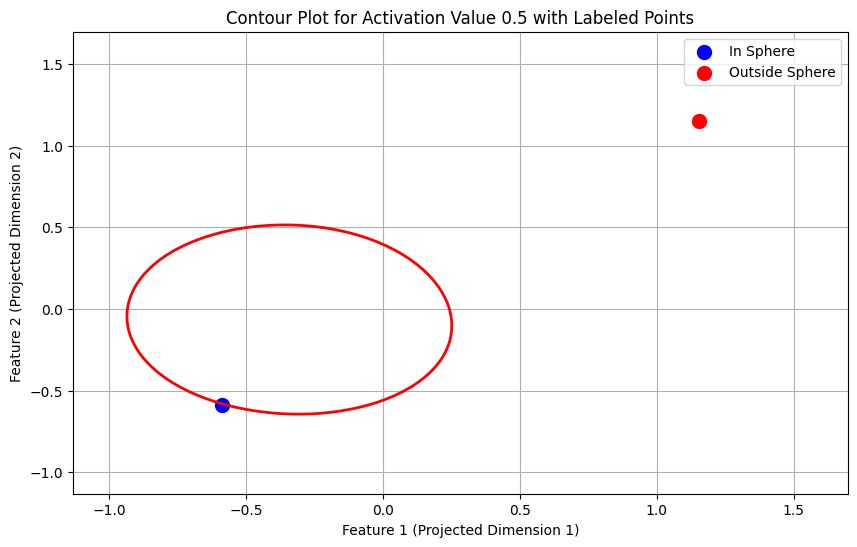

In [ ]:
# Step 1: Compute the projection matrix and translation vector
P, x0 = get_proj_mat(domain)  # P: (2, n), x0: (n,)

# Step 2: Project the domain to 2D
domain_2d = project_points(domain, P, x0)  # Shape: (m, 2)

# Step 3: Create a 2D grid in the projected space
x_min, x_max = domain_2d[:, 0].min(), domain_2d[:, 0].max()
y_min, y_max = domain_2d[:, 1].min(), domain_2d[:, 1].max()
x2 = np.linspace(x_min, x_max, 100)
y2 = np.linspace(y_min, y_max, 100)
X2, Y2 = np.meshgrid(x2, y2)  # Shapes: (100, 100)

# Vector from inside the sphere: tensor([0.0674, 0.1110, 0.6958])
# Vector from outside the sphere: tensor([-0.5406, -1.8895, -0.6052])

# Define the labeled points
labeled_points = {
    "In Sphere": np.array([0.0674, 0.1110, 0.6958]),
    "Outside Sphere": np.array([-0.5406, -1.8895, -0.6052]),
}

# Project the labeled points to 2D
projected_labeled_points = {label: project_points(point[None, :], P, x0)[0] for label, point in labeled_points.items()}

# Plot the contour for activation value 0.5
plt.figure(figsize=(10, 6))
contour = plt.contour(X2, Y2, Z, levels=[0.5], colors='red', linewidths=2)

# Plot the labeled points
for label, point in projected_labeled_points.items():
    if label == "In Sphere":
        plt.scatter(point[0], point[1], color='blue', label=label, s=100)  # Blue for inside
    elif label == "Outside Sphere":
        plt.scatter(point[0], point[1], color='red', label=label, s=100)  # Red for outside

# Add labels, title, and legend
plt.xlabel('Feature 1 (Projected Dimension 1)')
plt.ylabel('Feature 2 (Projected Dimension 2)')
plt.title('Contour Plot for Activation Value 0.5 with Labeled Points')
plt.legend()
plt.grid()
plt.show()
